In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('geolocation.csv', 'geolocation'),
    ('products.csv', 'products'),
    ('order_items.csv', 'order_items'),
    ('payments.csv', 'payments')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='j9847s188',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'D:/joti/dataset/ecommerce sales'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'{col} {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS {table_name} ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO {table_name} ({', '.join(['' + col + '' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing geolocation.csv
NaN values before replacement:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype:

In [2]:
import pandas as pd
import mysql.connector
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='j9847s188',
    database='ecommerce'
)

cursor = conn.cursor()
cursor.execute("SHOW TABLES")
tables = cursor.fetchall()



# 1. List all unique cities where customers are located.

In [5]:
query = "SELECT DISTINCT customer_city FROM customers"

# Execute the query
cursor.execute(query)

# Fetch the data
data = cursor.fetchall()
df = pd.DataFrame(data)
df.head()


,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [4]:
query = """ select count(order_id) 
            from orders where year(order_purchase_timestamp) = 2017 """

# Execute the query
cursor.execute(query)

# Fetch the data
data = cursor.fetchall()
"total orders placed in 2017 are ", data[0][0]

('total orders placed in 2017 are ', 45101)

# 3. Find the total sales per category.

In [6]:
query = """ SELECT  upper(p.product_category) category,round(sum(pt.payment_value),2) sales
FROM order_items o 
left join products p
on p.product_id = o.product_id
join payments pt
on pt.order_id = o.order_id
group by category
order by sales desc; """

# Execute the query
cursor.execute(query)

# Fetch the data
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["Category" , "Sales"]) 
df

,Category,Sales
0,BED TABLE BATH,1712553.67
1,HEALTH BEAUTY,1657373.12
2,COMPUTER ACCESSORIES,1585330.45
3,FURNITURE DECORATION,1430176.39
4,WATCHES PRESENT,1429216.68
...,...,...
69,PC GAMER,2174.43
70,HOUSE COMFORT 2,1710.54
71,CDS MUSIC DVDS,1199.43
72,FASHION CHILDREN'S CLOTHING,785.67


# 4. Calculate the percentage of orders that were paid in installments.

In [7]:
query = """ SELECT 
	sum(case when payment_installments >= 1 then 1 else 0 end)/count( payment_installments)*100 as percentage from payments """

# Execute the query
cursor.execute(query)

# Fetch the data
data = cursor.fetchall()
"percentage of orders paid in installments: ",data[0][0],"%"


('percentage of orders paid in installments: ', Decimal('99.9981'), '%')

# 5. Count the number of customers from each state. 

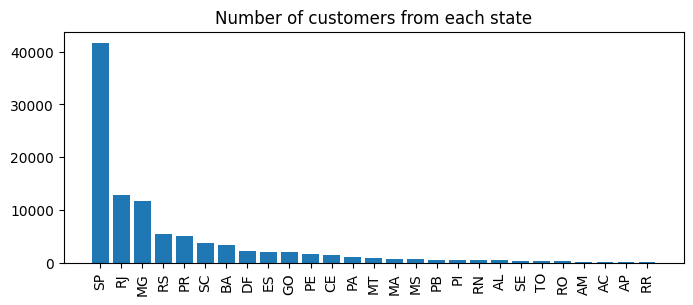

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

query = """ SELECT customer_state,count(customer_id) cnt FROM ecommerce.customers 
group by customer_state order by cnt desc"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data , columns = ["state" , "customer_count"])
plt.figure(figsize = (8,3))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation = 90)
plt.title("Number of customers from each state")
plt.show()

# 6. Calculate the number of orders per month in 2018.

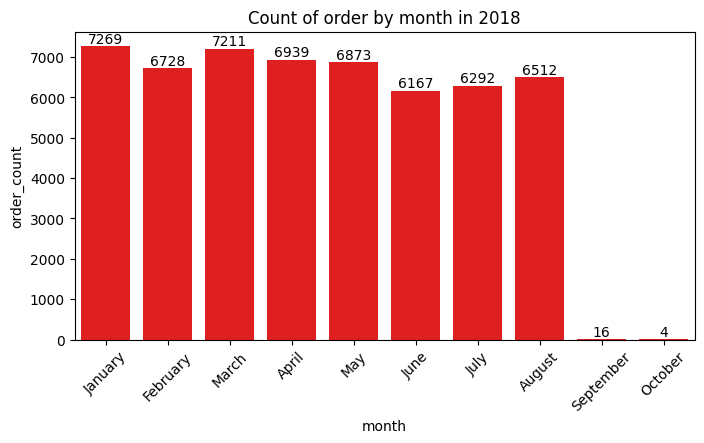

In [5]:
query = """ SELECT monthname(order_purchase_timestamp) as monthname,
count(order_id) as order_count FROM ecommerce.orders
where year(order_purchase_timestamp) = 2018 group by monthname"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data , columns = ["month" , "order_count"])
o = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]

plt.figure(figsize = (8,4))
ax = sns.barplot(x = df["month"],y= df["order_count"], data = df, order = o,color = "red")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of order by month in 2018")

plt.show()

# 7.Find the average number of products per order, grouped by customer city.

In [16]:
query = """with cte as(SELECT ot.order_id, c.customer_city,count(product_id) cnt FROM order_items ot
left join orders o on o.order_id = ot.order_id
left join customers c on c.customer_id = o.customer_id
 group by ot.order_id,o.customer_id,c.customer_city)
 select customer_city,round(avg(cnt),2) as avg from cte group by customer_city order by avg desc"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# 8.Calculate the percentage of total revenue contributed by each product category.

In [17]:
query = """SELECT upper(pd.product_category),round(sum(pt.payment_value)/(select sum(payment_value) from payments) * 100,2) as rev_per
 FROM order_items ot 
 left join products pd on ot.product_id = pd.product_id
 left join payments pt on ot.order_id = pt.order_id
 group by pd.product_category order by rev_per desc"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data,columns = ["product category", "revenue percentage"])
df.head(10)

,product category,revenue percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,WATCHES PRESENT,8.93
4,FURNITURE DECORATION,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


# 9. Identify the correlation between product price and the number of times a product has been purchased.

In [13]:
query = """select product_category,count(o.product_id) as cnt,round(avg(o.price),2) as price
from order_items o 
join products p 
on o.product_id = p.product_id
group by product_category"""

cursor.execute(query)

data = cursor.fetchall()
df = pd.DataFrame(data,columns = ["product_category","sales", "price"])

arr1 = df["sales"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("The Correlation between product price and product sales is:",a[0][1])

The Correlation between product price and product sales is: -0.10631514167157562


# 10.Calculate the total revenue generated by each seller, and rank them by revenue.

In [15]:
query = """with cte as (SELECT seller_id,round(sum(payment_value),2) as revenue
FROM ecommerce.order_items o 
join payments p 
on p.order_id =  o.order_id
group by seller_id)
select *, dense_rank() over(order by revenue desc) as rev_rank from cte """

cursor.execute(query)

data = cursor.fetchall()
df = pd.DataFrame(data,columns = ["seller_id","revenue", "revenue_rank"])
df.head()

,seller_id,revenue,revenue_rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5


# 11.Calculate the moving average of order values for each customer over their order history.

In [17]:
query = """select *,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
 rows between 2 preceding and current row) as mov_avg
from (SELECT o.customer_id,order_purchase_timestamp,p.payment_value as payment
FROM ecommerce.orders o
join payments p
on p.order_id = o.order_id) a
 """

cursor.execute(query)

data = cursor.fetchall()
df = pd.DataFrame(data,columns = ["customer_id", "order_purchase_timestamp", "payment","mov_avg"])
df.head(15)


,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.80,71.800003
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.40,49.400002
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.59,166.589996
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.23,85.230003
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.71,1255.709961


# 12.Calculate the cumulative sales per month for each year.

In [8]:
query = """select round(sum(payment_value),2) sales,round(sales,2) cumulative_sales,year,month 
from (select payment_value,sum(payment_value) over(partition by year(o.order_purchase_timestamp)
order by month(o.order_purchase_timestamp) asc) as sales,
year(o.order_purchase_timestamp) year,
month(o.order_purchase_timestamp) month 
FROM payments p join orders o 
on o.order_id = p.order_id 
order by year(o.order_purchase_timestamp) , month(o.order_purchase_timestamp)) a
group by sales,year,month """

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data,columns = ["sales", "cumulative_sales", "year","month"])
df

,sales,cumulative_sales,year,month
0,252.24,252.24,2016,9
1,59090.48,59342.72,2016,10
2,19.62,59362.34,2016,12
3,138488.04,138488.04,2017,1
4,291908.01,430396.05,2017,2
5,449863.60,880259.65,2017,3
6,417788.03,1298047.68,2017,4
7,592918.82,1890966.50,2017,5
8,511276.38,2402242.88,2017,6
9,592382.92,2994625.80,2017,7


# 13.Calculate the year-over-year growth rate of total sales.

In [5]:
query = """select year,sales,round((sales-prev_sales)/prev_sales*100,2) as yoy from 
(select round(sum(payment_value),2) sales, year(o.order_purchase_timestamp) year, 
lag(round(sum(payment_value),2)) over(order by year(o.order_purchase_timestamp))as prev_sales
FROM payments p
join orders o 
on o.order_id = p.order_id
group by year) a
 """

cursor.execute(query)

data = cursor.fetchall()
df = pd.DataFrame(data,columns = [ "year","sales","yoy%"])
df


,year,sales,yoy%
0,2016,59362.34,NaN
1,2017,7249746.73,12112.7
2,2018,8699763.05,20.0


# 14.Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [4]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cursor.execute(query)
data = cursor.fetchall()

"the retention rate of customers is",data

('the retention rate of customers', [(None,)])

# 15.Identify the top 3 customers who spent the most money in each year.

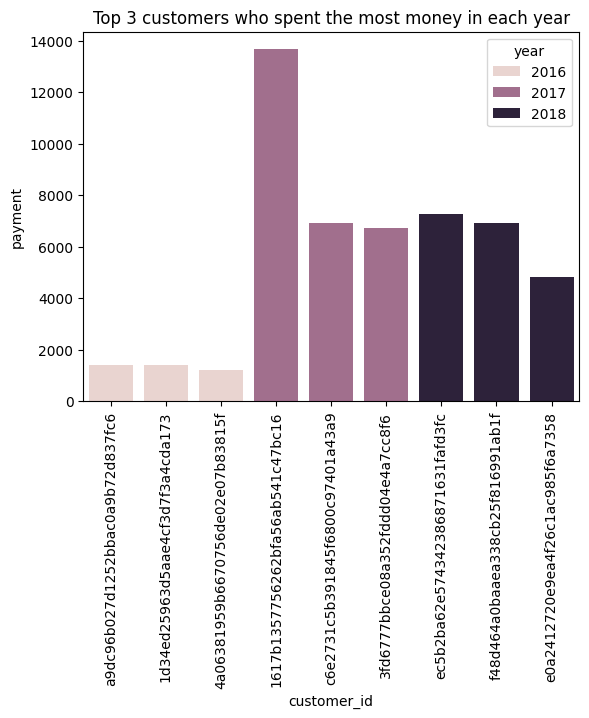

In [20]:
query = """with cte as (select *, rank() over(partition by year order by payment desc) as r 
from (select o.customer_id,year(o.order_purchase_timestamp) year,
round(sum(p.payment_value),2) payment FROM ecommerce.orders o join payments p 
on p.order_id = o.order_id
group by o.customer_id, year
order by year asc,payment desc) a)
select customer_id, year,payment from cte where r <= 3"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data,  columns = ["customer_id" ,"year","payment"])
sns.barplot(x = "customer_id",y = "payment", data = df , hue = "year")
plt.xticks(rotation = 90)
plt.title("Top 3 customers who spent the most money in each year")
plt.show()